In [1]:
# Importing packages:
import numpy as np
import pandas as pd
import scipy.interpolate
import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
import itertools
from IPython.display import Audio, display
import glob
import os 
import PIL
from random import randint
import albumentations as A

from PIL import ImageOps


# Importing packages from skimage:
from skimage.io import imread
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.transform import resize

/zhome/41/f/212410/venv_dl16/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Setting up paths

path_real = '/dtu/blackhole/1d/155421/cars_dataset_aug_25/0_real'
path_fake = '/dtu/blackhole/1d/155421/cars_dataset_aug_25/1_fake'

org_path_real = '/dtu/blackhole/1d/155421/cars_dataset/cars/0_real'
org_path_fake = '/dtu/blackhole/1d/155421/cars_dataset/cars/1_fake'


print("Files in real images folder:", os.listdir(path_real))
print("Files in fake images folder:", os.listdir(path_fake))

print("Files in real images folder:", os.listdir(org_path_real))
print("Files in fake images folder:", os.listdir(org_path_fake))

Files in real images folder: ['.DS_Store', '00001.png', '00002.png', '00008.png', '00009.png', '00010.png', '00017.png', '00015.png', '00019.png', '00018.png', '00020.png', '00023.png', '00026.png', '00030.png', '00036.png', '00037.png', '00040.png', '00042.png', '00047.png', '00048.png', '00051.png', '00057.png', '00065.png', '00067.png', '00068.png', '00069.png', '00081.png', '00089.png', '00084.png', '00090.png', '00091.png', '00095.png', '00097.png', '00098.png', '00099.png', '00102.png', '00103.png', '00105.png', '00106.png', '00107.png', '00111.png', '00114.png', '00115.png', '00118.png', '00120.png', '00122.png', '00123.png', '00129.png', '00130.png', '00132.png', '00137.png', '00140.png', '00142.png', '00148.png', '00151.png', '00158.png', '00160.png', '00162.png', '00166.png', '00167.png', '00168.png', '00172.png', '00173.png', '00174.png', '00176.png', '00178.png', '00179.png', '00183.png', '00185.png', '00186.png', '00187.png', '00188.png', '00189.png', '00190.png', '00193.p

In [3]:
def crawl_directories(directory):
    results = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):
                results.append(os.path.join(root, file))
    return results

fake_images = crawl_directories(path_fake)
real_images = crawl_directories(path_real)

org_fake_images = crawl_directories(org_path_fake)
org_real_images = crawl_directories(org_path_real)


In [4]:
# TRANSFORMED
cars_real = []
#for carpath in real_images_paths:
for carpath in real_images:
  try:
      image = cv2.imread(carpath)
      if image is not None:  # Check if loading was successful
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
          cars_real.append(image)

  except Exception as e:
      print(f"Failed to load {carpath}: {e}")


cars_synth = []
#for carpath in fake_images_paths:
for carpath in fake_images:
  try:
      image = cv2.imread(carpath)
      if image is not None:  # Check if loading was successful
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
      cars_synth.append(image)

  except Exception as e:
      print(f"Failed to load {carpath}: {e}")

In [5]:
# ORIGINAL

org_cars_real = []
#for carpath in real_images_paths:
for carpath in org_real_images:
  try:
      image = cv2.imread(carpath)
      if image is not None:  # Check if loading was successful
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        org_cars_real.append(image)

  except Exception as e:
      print(f"Failed to load {carpath}: {e}")


org_cars_synth = []
#for carpath in fake_images_paths:
for carpath in org_fake_images:
  try:
      image = cv2.imread(carpath)
      if image is not None:  # Check if loading was successful
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        org_cars_synth.append(image)

  except Exception as e:
      print(f"Failed to load {carpath}: {e}")

In [10]:

def pad_images_to_max_size(images):
    """
    Removes the top 5% of the largest images (by area) and pads remaining images 
    to the maximum width and height found among them.
    
    Args:
        images (list of np.ndarray): List of images as NumPy arrays.
        
    Returns:
        list of np.ndarray: List of padded images, all of the same size.
        tuple: The maximum height and width (max_height, max_width).
    """
    # Ensure the input is a list of images
    if not all(isinstance(img, np.ndarray) for img in images):
        raise ValueError("All elements in the input list must be images (NumPy arrays).")
    
    # Compute areas of all images
    areas = np.array([img.shape[0] * img.shape[1] for img in images])
    
    # Determine threshold for the top 5% largest areas
    threshold_area = np.percentile(areas, 85)
    
    # Filter out the top 5% largest images
    filtered_images = [img for img in images if img.shape[0] * img.shape[1] <= threshold_area]
    
    if not filtered_images:
        raise ValueError("No images left after removing the top 15% largest images.")
    
    # Find maximum dimensions among the filtered images
    max_height = max(img.shape[0] for img in filtered_images)
    max_width = max(img.shape[1] for img in filtered_images)
    print(f"Max height: {max_height}, Max width: {max_width}")
    
    padded_images = []
    
    # Pad each image to the maximum dimensions
    for img in filtered_images:
        height, width = img.shape[:2]
        
        # Calculate padding
        top = (max_height - height) // 2
        bottom = max_height - height - top
        left = (max_width - width) // 2
        right = max_width - width - left
        
        # Apply padding
        padded_image = cv2.copyMakeBorder(
            img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )
        padded_images.append(padded_image)
    
    # Verify that all images are the same size
    for img in padded_images:
        assert img.shape[:2] == (max_height, max_width), "Padding failed to make all images uniform."
    
    return padded_images, (max_height, max_width)




In [38]:
cars_realPP, (max_height, max_width) = pad_images_to_max_size(cars_real)

print(f"All images padded to size: {max_height}x{max_width}")

org_cars_realPP, (max_height, max_width) = pad_images_to_max_size(org_cars_real)

print(f"All images padded to size: {max_height}x{max_width}")


Max height: 1023, Max width: 1367
All images padded to size: 1023x1367
Max height: 1023, Max width: 1367
All images padded to size: 1023x1367


In [12]:


def pad_images_to_specified_size(images, target_size):
    """
    Pads all images in a list to the specified target size.
    
    Args:
        images (list of np.ndarray): List of images as NumPy arrays.
        target_size (tuple): Target size as (height, width).
        
    Returns:
        list of np.ndarray: List of padded images, all of the specified size.
    """
    target_height, target_width = target_size
    
    # Ensure the input is a list of images
    if not all(isinstance(img, np.ndarray) for img in images):
        raise ValueError("All elements in the input list must be images (NumPy arrays).")
    
    padded_images = []
    
    for img in images:
        height, width = img.shape[:2]
        
        if height > target_height or width > target_width:
            raise ValueError(f"Image size ({height}, {width}) exceeds target size ({target_height}, {target_width}).")
        
        # Calculate padding
        top = (target_height - height) // 2
        bottom = target_height - height - top
        left = (target_width - width) // 2
        right = target_width - width - left
        
        # Apply padding
        padded_image = cv2.copyMakeBorder(
            img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )
        padded_images.append(np.array(padded_image))
    
    # Verify that all images are of the specified size
    for img in padded_images:
        assert img.shape[:2] == (target_height, target_width), "Padding failed to make all images the specified size."
    
    return np.array(padded_images)




In [39]:
target_size = (max_height, max_width)

cars_synthPP = pad_images_to_specified_size(cars_synth, target_size)

org_cars_synthPP = pad_images_to_specified_size(org_cars_synth, target_size)

print(cars_synthPP.shape)

(3120, 1023, 1367, 3)


Processing synthetic images...


Processing Groups: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [22:24<00:00, 672.48s/it]


Processing real images...


Processing Groups: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [20:26<00:00, 613.37s/it]


Computing differences...
Plotting results...


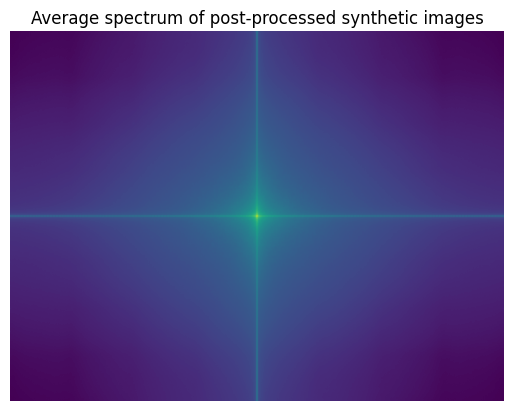

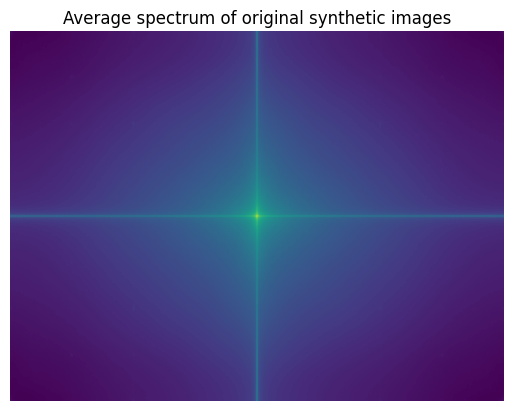

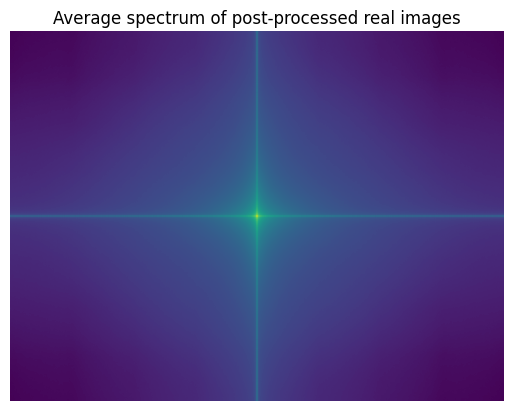

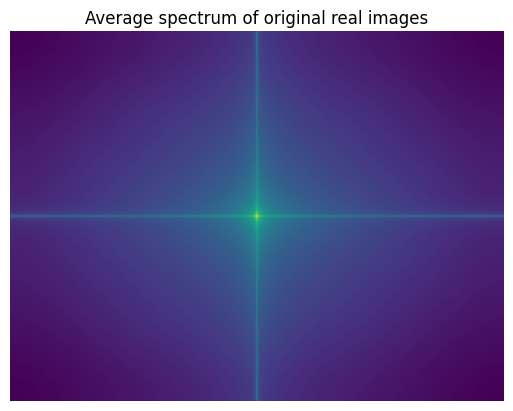

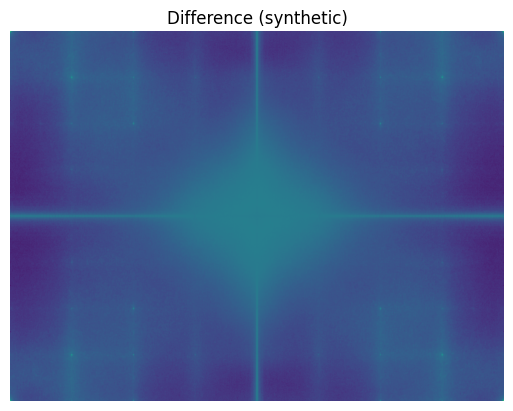

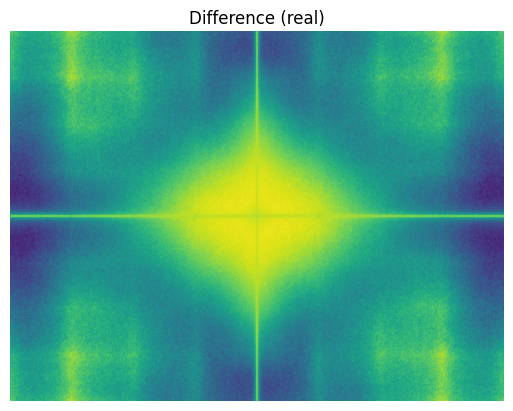

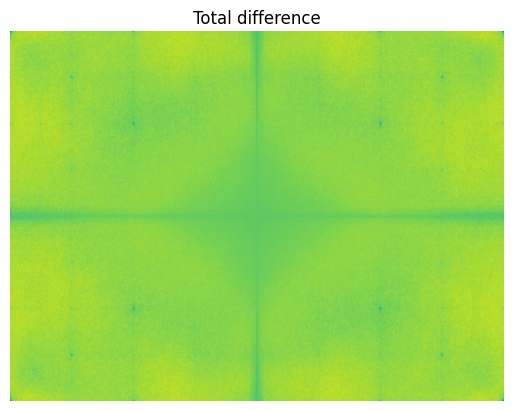

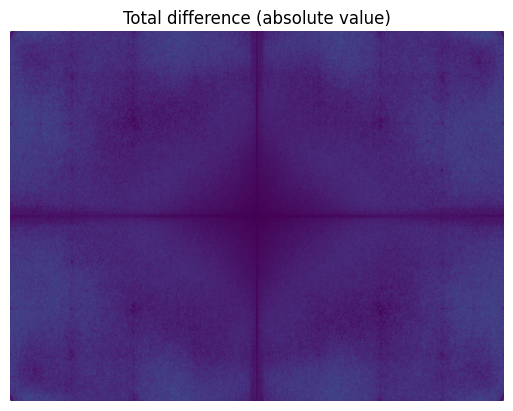

In [14]:
from scipy.fft import fft2, fftshift
from multiprocessing import Pool
from tqdm import tqdm



# Precompute radial grid for a given image size
def compute_radial_bins(image_shape):
    ny, nx = image_shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2
    r = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2).astype(np.int32)
    return r

# Optimized spectra function with progress bar
def spectra(image_list):
    
    rapsd = []
    power_spectra = []

    # Precompute radial grid (assumes all images have the same shape)
    radial_bins = compute_radial_bins(image_list[0].shape[:2])

    # Process images with progress bar
    for image_data in tqdm(image_list, desc="Processing Images", unit="image"):
        # Sum power spectra across all channels
        pow_spec_accum = np.zeros_like(radial_bins, dtype=np.float64)
        log_spec_accum = np.zeros_like(radial_bins, dtype=np.float64)

        for channel in range(image_data.shape[2]):
            channel_data = image_data[..., channel]

            # Compute FFT, power spectrum, and log spectrum
            f_transform = fft2(channel_data)
            f_transform_shifted = fftshift(f_transform)
            pow_spec = np.abs(f_transform_shifted) ** 2
            log_spec = np.log1p(np.abs(f_transform_shifted))  # log(1 + abs)

            pow_spec_accum += pow_spec
            log_spec_accum += log_spec

        # Average across channels
        pow_spec_mean = pow_spec_accum / image_data.shape[2]
        log_spec_mean = log_spec_accum / image_data.shape[2]

        # Append log spectrum
        power_spectra.append(log_spec_mean)

        # Radial binning for rapsd
        psd = np.bincount(radial_bins.ravel(), weights=pow_spec_mean.ravel()) / np.bincount(radial_bins.ravel())
        rapsd.append(psd)

    return rapsd, power_spectra

# Averaging function
def average_spectra(spectra_list):
    return np.mean(spectra_list, axis=0)

# Parallel processing helper
def process_spectra(image_list):
    rapsd, power_spectra = spectra(image_list)
    return average_spectra(rapsd), average_spectra(power_spectra)

def parallel_process(image_groups, num_workers=None):
    
    with Pool(processes=num_workers) as pool:
        results = list(tqdm(pool.imap(process_spectra, image_groups), total=len(image_groups), desc="Processing Groups"))
    return results


num_workers = 12
# Example workflow 
print("Processing synthetic images...")
synth_results = parallel_process([cars_synthPP, org_cars_synthPP], num_workers = num_workers)
del cars_synthPP; del org_cars_synthPP
rapsd_synth_avg, power_spectra_synth_avg = synth_results[0]
org_rapsd_synth_avg, org_power_spectra_synth_avg = synth_results[1]

print("Processing real images...")
real_results = parallel_process([cars_realPP, org_cars_realPP], num_workers = num_workers)
del cars_realPP; del org_cars_realPP
rapsd_real_avg, power_spectra_real_avg = real_results[0]
org_rapsd_real_avg, org_power_spectra_real_avg = real_results[1]

print("Computing differences...")
diff_synth = org_power_spectra_synth_avg - power_spectra_synth_avg
diff_real = org_power_spectra_real_avg - power_spectra_real_avg
total_diff = diff_real - diff_synth
abs_total_diff = np.abs(total_diff)

print("Plotting results...")
# Plotting helper
def plot_image(data, title):
    plt.figure()
    plt.imshow(data)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot results
plot_image(power_spectra_synth_avg, "Average spectrum of post-processed synthetic images")
plot_image(org_power_spectra_synth_avg, "Average spectrum of original synthetic images")
plot_image(power_spectra_real_avg, "Average spectrum of post-processed real images")
plot_image(org_power_spectra_real_avg, "Average spectrum of original real images")
plot_image(diff_synth, "Difference (synthetic)")
plot_image(diff_real, "Difference (real)")
plot_image(total_diff, "Total difference")
plot_image(abs_total_diff, "Total difference (absolute value)")


Computing differences...
Plotting results...


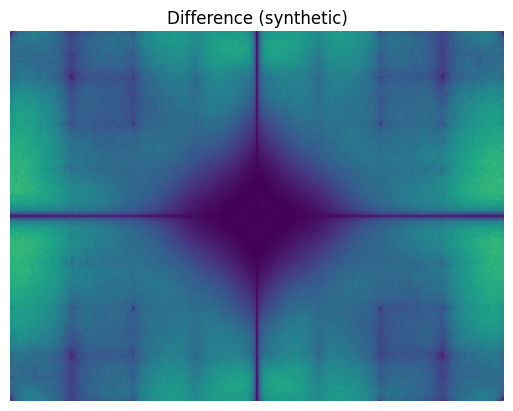

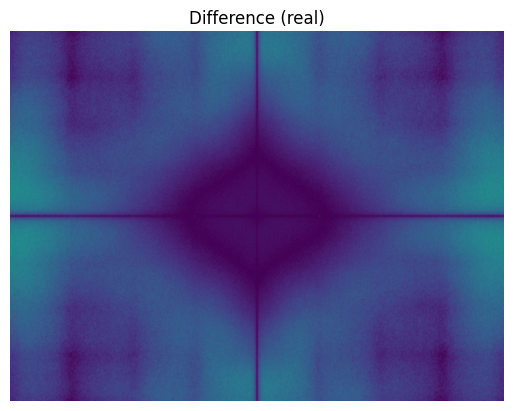

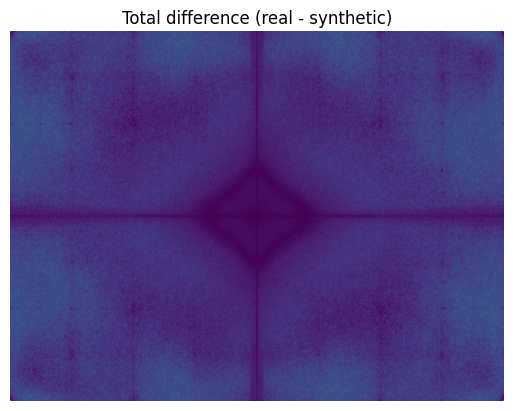

In [33]:
print("Computing differences...")
diff_synth = np.abs(org_power_spectra_synth_avg - power_spectra_synth_avg)
diff_real = np.abs(org_power_spectra_real_avg - power_spectra_real_avg)
total_diff = np.abs(diff_real - diff_synth)
#abs_total_diff = np.abs(total_diff)



print("Plotting results...")
# Plotting helper
def plot_image(data, title):
    plt.figure()
    im = plt.imshow(data)
    plt.axis('off')
    plt.title(title)
    #plt.colorbar(im)
    im.set_clim(0, 0.8)  # Set color limits on the image object
    plt.show()

# Plot results
#plot_image(power_spectra_synth_avg, "Average spectrum of post-processed synthetic images")
#plot_image(org_power_spectra_synth_avg, "Average spectrum of original synthetic images")
#plot_image(power_spectra_real_avg, "Average spectrum of post-processed real images")
#plot_image(org_power_spectra_real_avg, "Average spectrum of original real images")
plot_image(diff_synth, "Difference (synthetic)")
plot_image(diff_real, "Difference (real)")
plot_image(total_diff, "Total difference (real - synthetic)")
#plot_image(abs_total_diff, "Total difference (absolute value)")


In [41]:
# Calculating PSNR values

def psnr_calculation(transformed_list, original_list):
    # Ensure both lists have the same length
    if len(transformed_list) != len(original_list):
        raise ValueError("The lengths of the transformed and original image lists must be the same.")
    
    psnr_values = []  # To store PSNR values for each image pair

    for img, org in zip(transformed_list, original_list):
        # Resize original image to match transformed image shape only when necessary
        if org.shape != img.shape:
            reshaped_original = resize(org, img.shape, anti_aliasing=True, preserve_range=True)
        else:
            reshaped_original = org  # No need to resize if shapes match

        # Calculate PSNR with the appropriate data range
        psnr_value = psnr(reshaped_original, img, data_range=reshaped_original.max() - reshaped_original.min())
        psnr_values.append(psnr_value)

    return psnr_values


# On padded images

padded_synthetic_psnr = psnr_calculation(cars_synthPP, org_cars_synthPP)

padded_real_psnr = psnr_calculation(cars_realPP, org_cars_realPP)


# On not padded images

synthetic_psnr = psnr_calculation(cars_synth, org_cars_synth)

real_psnr = psnr_calculation(cars_real, org_cars_real)


In [43]:
# Calculating averages

print("The average PSNR value for padded synthetic images: ", np.mean(padded_synthetic_psnr))
print("The average PSNR value for padded real images: ", np.mean(padded_real_psnr))
print("The average PSNR value for synthetic images: ", np.mean(synthetic_psnr))
print("The average PSNR value for real images: ", np.mean(real_psnr)) # these had to be resized



The average PSNR value for padded synthetic images:  33.94356496446609
The average PSNR value for padded real images:  34.5853032008613
The average PSNR value for synthetic images:  26.656580104528704
The average PSNR value for real images:  26.04971883308557


# SYNTHETIC

rapsd_synth_trans, power_spectra_synth_trans = spectra(cars_synth, len(cars_synth))
rapsd_synth_avg = average_spectra(rapsd_synth_trans)
power_spectra_synth_avg = average_spectra(power_spectra_synth_trans)  

org_rapsd_synth, org_power_spectra_synth = spectra(org_cars_synth, len(org_cars_synth))
org_rapsd_synth_avg = average_spectra(org_rapsd_synth)
org_power_spectra_synth_avg = average_spectra(org_power_spectra_synth)  


# REAL

rapsd_real_trans, power_spectra_real = spectra(cars_realPP, len(cars_realPP))
rapsd_real_avg = average_spectra(rapsd_real_trans)
power_spectra_real_avg = average_spectra(power_spectra_real_trans)  

org_rapsd_real, org_power_spectra_real = spectra(org_cars_realPP, len(org_cars_realPP))
org_rapsd_real_avg = average_spectra(org_rapsd_real)
org_power_spectra_real_avg = average_spectra(org_power_spectra_real)  


diff_synth = org_cars_synthPP - cars_synthPP
diff_real = org_cars_realPP - cars_realPP
total_diff = diff_real - diff_synth
abs_total_diff = np.abs(total_diff)



# Plotting the average spectrum
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(power_spectra_synth_avg)
plt.axis('off')
plt.title("Average spectrum of post-processed synthetic images")

plt.subplot(1, 2, 2)
plt.imshow(org_power_spectra_synth_avg)
plt.axis('off')
plt.title("Average spectrum of original synthetic images")

plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(diff_synth)
plt.title("Difference (synthetic)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(diff_real)
plt.title("Difference (real)")
plt.axis('off')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(total_diff)
plt.title("Total difference")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(abs_total_diff)
plt.title("Total difference (absolute value)")
plt.axis('off')

plt.tight_layout()
plt.show()






